# Multimodal Visual sentiment model

In [1]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import (
    DataLoader,
    RandomSampler,
    TensorDataset,
    SequentialSampler,
)
from torch import optim
from torch.nn import functional as F
from PIL import Image
from transformers import (
    ViTForImageClassification,
    ViTFeatureExtractor,
    BertForSequenceClassification,
    BertTokenizer,
    get_linear_schedule_with_warmup,
)

from typing import Any, Dict, List, Tuple

from tqdm import tqdm

import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import ConfusionMatrixDisplay, f1_score, classification_report, confusion_matrix

import warnings

warnings.filterwarnings("ignore")
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

In [2]:
"""Settings"""

BATCH_SIZE = 16

BERT_MODEL = "DeepPavlov/rubert-base-cased"
VIT_MODEL = "google/vit-base-patch16-224"

VISUAL_OUTPUT = 64
BERT_OUTPUT = 64
FUSION_DIM = 64

DROPOUT = 0.2

MAX_SEQ_LENGTH = 128

AVAILABLE_GPU = True

IMAGE_PARENT_PATH = ".."

In [3]:
if torch.cuda.is_available() and AVAILABLE_GPU:
    device = torch.device("cuda")
    print(f"Available GPU devices: {torch.cuda.device_count()}")
    print(f"Used GPU device: {torch.cuda.get_device_name()}")
    print(torch.cuda.memory_summary())

else:
    print("There are no GPU available")
    device = torch.device("cpu")

device

Available GPU devices: 1
Used GPU device: NVIDIA GeForce RTX 3070 Ti
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |       0 B  |
|       from small pool |       0 B  |       0 B  |       0 B  |       0 B  |
|---------------------------------------------------------------------------|
| Active memory         |       0 B  |       0 B  |       0 B  |       0 

device(type='cuda')

In [4]:
torch.cuda.empty_cache()

In [5]:
vit_feature_extractor = ViTFeatureExtractor.from_pretrained(VIT_MODEL)
bert_feature_extractor = BertTokenizer.from_pretrained(BERT_MODEL)

In [6]:
def transform_sentences(sentences: List[str]) -> Tuple[torch.Tensor, torch.Tensor]:
    """Transform sentences to vectors."""
    input_ids = []
    attention_masks = []
    for sentence in tqdm(sentences):
        encoded_dict = bert_feature_extractor.encode_plus(
            sentence,
            add_special_tokens=True,
            truncation=True,
            max_length=MAX_SEQ_LENGTH,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors="pt",
        )
        input_ids.append(encoded_dict.get("input_ids"))
        attention_masks.append(encoded_dict.get("attention_mask"))

    return torch.cat(input_ids, dim=0), torch.cat(attention_masks, dim=0)


def transform_images(image_paths: List[str], image_feature_extractor) -> torch.Tensor:
    """Extract features from image."""
    pixel_values = []
    for image_path in tqdm(image_paths):
        pil_image = Image.open(image_path)
        pixel_value = image_feature_extractor(pil_image, return_tensors="pt").get("pixel_values")
        pixel_values.append(pixel_value)
    return torch.cat(pixel_values, dim=0)

In [7]:
image_info_df = pd.read_csv("../image_sentiment_data_with_captions.csv")
image_info_df["image_path"] = image_info_df["image_path"].apply(lambda x: f"{IMAGE_PARENT_PATH}/" + str(x))
image_info_df.head()

,image_path,sentiment,caption,clean_caption
0,../data/preprocess_images/positive/104505632.jpg,positive,"Женщина разговаривает по мобильному телефону, ...",женщина разговаривать мобильный телефон держат...
1,../data/preprocess_images/positive/1059249846.jpg,positive,Женщина сидит на скамейке в парке с зонтиком.,женщина сидеть скамейка парк зонтик
2,../data/preprocess_images/positive/108501238.jpg,positive,Женщина в очках и с длинными волосами держит м...,женщина очки длинный волос держать мобильный т...
3,../data/preprocess_images/positive/1089046474.jpg,positive,Вид на город с высоты птичьего полета.,вид город высота птичий полет
4,../data/preprocess_images/positive/1096822187.jpg,positive,Мужчина и женщина позируют фотографу.,мужчина женщина позировать фотограф


In [8]:
image_info_df.shape

(3255, 4)

In [9]:
NUM_SAMPLES = 0
if NUM_SAMPLES:
    image_info_df = image_info_df.sample(NUM_SAMPLES)

In [10]:
label_encoder = LabelEncoder()
image_info_df["label"] = label_encoder.fit_transform(image_info_df["sentiment"])
image_info_df.head()

,image_path,sentiment,caption,clean_caption,label
0,../data/preprocess_images/positive/104505632.jpg,positive,"Женщина разговаривает по мобильному телефону, ...",женщина разговаривать мобильный телефон держат...,2
1,../data/preprocess_images/positive/1059249846.jpg,positive,Женщина сидит на скамейке в парке с зонтиком.,женщина сидеть скамейка парк зонтик,2
2,../data/preprocess_images/positive/108501238.jpg,positive,Женщина в очках и с длинными волосами держит м...,женщина очки длинный волос держать мобильный т...,2
3,../data/preprocess_images/positive/1089046474.jpg,positive,Вид на город с высоты птичьего полета.,вид город высота птичий полет,2
4,../data/preprocess_images/positive/1096822187.jpg,positive,Мужчина и женщина позируют фотографу.,мужчина женщина позировать фотограф,2


In [11]:
train_image_info_df, test_image_info_df = train_test_split(image_info_df, test_size=0.2)
train_image_info_df, valid_image_info_df = train_test_split(train_image_info_df, test_size=0.2)

In [12]:
train_input_ids, train_attention_masks = transform_sentences(train_image_info_df["clean_caption"].to_list())
train_image_features = transform_images(train_image_info_df["image_path"].to_list(), vit_feature_extractor)
train_labels = F.one_hot(torch.tensor(train_image_info_df["label"].to_list()).to(torch.int64)).to(torch.float64)

100%|██████████| 2083/2083 [01:22<00:00, 25.27it/s]


In [13]:
valid_input_ids, valid_attention_masks = transform_sentences(valid_image_info_df["clean_caption"].to_list())
valid_image_features = transform_images(valid_image_info_df["image_path"].to_list(), vit_feature_extractor)
valid_labels = F.one_hot(torch.tensor(valid_image_info_df["label"].to_list()).to(torch.int64)).to(torch.float64)

100%|██████████| 521/521 [00:20<00:00, 25.96it/s]


In [14]:
test_input_ids, test_attention_masks = transform_sentences(test_image_info_df["clean_caption"].to_list())
test_image_features = transform_images(test_image_info_df["image_path"].to_list(), vit_feature_extractor)
test_labels = F.one_hot(torch.tensor(test_image_info_df["label"].to_list()).to(torch.int64)).to(torch.float64)

100%|██████████| 651/651 [00:28<00:00, 22.52it/s]


In [15]:
train_dataset = TensorDataset(train_input_ids, train_attention_masks, train_image_features, train_labels)
valid_dataset = TensorDataset(valid_input_ids, valid_attention_masks, valid_image_features, valid_labels)
test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_image_features, test_labels)

In [16]:
train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    sampler=RandomSampler(train_dataset),
)
valid_dataloader = DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE,
    sampler=SequentialSampler(valid_dataset),
)
test_dataloader = DataLoader(test_dataset)

In [17]:
def f1_weighted_score(preds: torch.Tensor, labels: torch.Tensor):
    pred_numpy = preds.cpu().detach().numpy()
    labels_numpy = labels.cpu().detach().numpy()
    pred_flatten = np.argmax(pred_numpy, axis=1).flatten()
    labels_flatten = np.argmax(labels_numpy, axis=1).flatten()
    return f1_score(labels_flatten.astype(np.int32), pred_flatten.astype(np.int32), average="weighted")

In [18]:
class MultimodalVisualSentimentModel(torch.nn.Module):

    def __init__(
            self,
            num_classes: int,
            language_module,
            visual_module,
            language_model_dim: int,
            visual_model_dim: int,
            fusion_dim: int,
            dropout_prob: float,
    ):
        super().__init__()
        self.language_module = language_module
        self.visual_module = visual_module
        self.fusion = torch.nn.Linear(
            in_features=(language_model_dim + visual_model_dim),
            out_features=fusion_dim,
        )
        self.dropout = torch.nn.Dropout(p=dropout_prob)
        self.classifier = torch.nn.Linear(in_features=fusion_dim, out_features=num_classes)
        self.softmax = torch.nn.Softmax()
        self.relu = torch.nn.ReLU()

    def forward(
            self,
            input_ids: torch.Tensor,
            attention_mask: torch.Tensor,
            image_features: torch.Tensor,
    ):
        language_output = self.language_module(input_ids, attention_mask=attention_mask).logits
        visual_output = self.visual_module(image_features).logits

        combined_output = torch.cat([language_output, visual_output], dim=1)

        fused_output = self.dropout(self.fusion(combined_output))

        model_logits = self.softmax(self.classifier(fused_output))

        return model_logits

In [19]:
NUM_CLASSES = len(label_encoder.classes_)

In [20]:
visual_model = ViTForImageClassification.from_pretrained(
    VIT_MODEL,
    num_labels=VISUAL_OUTPUT,
    ignore_mismatched_sizes=True,
)
language_model = BertForSequenceClassification.from_pretrained(
    BERT_MODEL,
    num_labels=BERT_OUTPUT,
    ignore_mismatched_sizes=True,
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([64, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([64]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias']
- This IS ex

In [21]:
multimodal_model = MultimodalVisualSentimentModel(
    num_classes=NUM_CLASSES,
    language_module=language_model,
    visual_module=visual_model,
    language_model_dim=BERT_OUTPUT,
    visual_model_dim=VISUAL_OUTPUT,
    fusion_dim=FUSION_DIM,
    dropout_prob=DROPOUT,
)
multimodal_model.to(device)

MultimodalVisualSentimentModel(
  (language_module): BertForSequenceClassification(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(119547, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768

In [22]:
LEARNING_RATE = 2e-5
NUM_EPOCHS = 10
EPS = 1e-7

NUM_WARMUP_STEPS = 0
NUM_TRAINING_STEPS = len(train_dataloader) * NUM_EPOCHS

In [23]:
optimizer = optim.RMSprop(multimodal_model.parameters(recurse=True), lr=LEARNING_RATE, eps=EPS)
loss_function = torch.nn.CrossEntropyLoss().to(device)
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=NUM_WARMUP_STEPS,
    num_training_steps=NUM_TRAINING_STEPS,
)

In [24]:
import matplotlib.pyplot as plt


def plot_history(history: dict) -> None:
    train = history.get("train")
    valid = history.get("valid")
    plt.title("Loss")
    plt.plot(train.get("loss"), label="train")
    plt.plot(valid.get("loss"), label="valid")
    plt.legend()
    plt.show()
    plt.title("Accuracy")
    plt.plot(train.get("accuracy"), label="train")
    plt.plot(valid.get("accuracy"), label="valid")
    plt.legend()
    plt.show()

In [25]:
def train(
        model: torch.nn.Module,
        dataloader: DataLoader,
        optim: optim.Optimizer,
        loss_func: torch.nn.Module,
        warmup_scheduler=scheduler,
) -> Tuple[float, float]:
    loss = 0
    accuracy = 0
    model.train()
    for input_ids, attention_mask, image_features, sentiment in dataloader:
        optim.zero_grad()

        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        image_features = image_features.to(device)

        sentiment = sentiment.to(device)

        preds = model(input_ids, attention_mask, image_features)

        loss_current = loss_func(preds.to(device), sentiment)

        accuracy_curr = f1_weighted_score(preds, sentiment)

        loss_current.backward()
        optim.step()
        warmup_scheduler.step()

        loss += loss_current.item()
        accuracy += accuracy_curr.item()
    return loss / len(dataloader), accuracy / len(dataloader)

In [26]:
def validate(
        model: torch.nn.Module,
        dataloader: DataLoader,
        loss_func: torch.nn.Module,
) -> Tuple[float, float]:
    loss = 0
    accuracy = 0
    model.eval()
    with torch.no_grad():
        for input_ids, attention_mask, image_features, sentiment in dataloader:
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            image_features = image_features.to(device)

            sentiment = sentiment.to(device)

            preds = model(input_ids, attention_mask, image_features)

            loss_current = loss_func(preds.to(device), sentiment)

            accuracy_current = f1_weighted_score(preds, sentiment)

            loss += loss_current.item()
            accuracy += accuracy_current.item()
    return loss / len(dataloader), accuracy / len(dataloader)

In [27]:
def training(
        model: torch.nn.Module,
        train_data: DataLoader,
        validate_data: DataLoader,
        optim: optim.Optimizer,
        loss_func: torch.nn.Module,
        num_epochs: int = 10,
) -> Dict[str, Any]:
    best_loss = float('inf')
    history = {
        "train": {
            "loss": [],
            "accuracy": [],
        },
        "valid": {
            "loss": [],
            "accuracy": [],
        }
    }
    for epoch in range(num_epochs):
        print(f"{'=' * 15} Epoch: {epoch + 1} {'=' * 15}")
        time_start = time.time()
        train_loss, train_accuracy = train(model, train_data, optim, loss_func)
        print(f"Train: loss={train_loss:.3f}, accuracy={train_accuracy:.3f}")
        validation_loss, validation_accuracy = validate(model, validate_data, loss_func)
        print(f"Validation: loss={validation_loss:.3f}, accuracy={validation_accuracy:.3f}")
        time_end = time.time()
        time_delta = time_end - time_start
        if validation_loss < best_loss:
            best_loss = validation_loss
        history["train"]["accuracy"].append(train_accuracy)
        history["train"]["loss"].append(train_loss)
        history["valid"]["accuracy"].append(validation_accuracy)
        history["valid"]["loss"].append(validation_loss)
        print(f"Time elapsed: {time_delta:.2f} s\n{'=' * 40}")
    return history

In [28]:
multimodal_history = training(
    multimodal_model,
    train_dataloader,
    test_dataloader,
    optimizer,
    loss_function,
    num_epochs=NUM_EPOCHS,
)

=============== Epoch: 1 ===============
Train: loss=0.906, accuracy=0.598
Validation: loss=0.859, accuracy=0.704
Time elapsed: 72.93 s
=============== Epoch: 2 ===============
Train: loss=0.787, accuracy=0.691
Validation: loss=0.829, accuracy=0.727
Time elapsed: 63.30 s
=============== Epoch: 3 ===============
Train: loss=0.718, accuracy=0.815
Validation: loss=0.813, accuracy=0.731
Time elapsed: 61.29 s
=============== Epoch: 4 ===============
Train: loss=0.666, accuracy=0.901
Validation: loss=0.814, accuracy=0.728
Time elapsed: 60.97 s
=============== Epoch: 5 ===============
Train: loss=0.626, accuracy=0.941
Validation: loss=0.832, accuracy=0.704
Time elapsed: 60.47 s
=============== Epoch: 6 ===============
Train: loss=0.606, accuracy=0.956
Validation: loss=0.825, accuracy=0.708
Time elapsed: 61.36 s
=============== Epoch: 7 ===============
Train: loss=0.590, accuracy=0.968
Validation: loss=0.839, accuracy=0.697
Time elapsed: 61.97 s
=============== Epoch: 8 ===============
Train: 

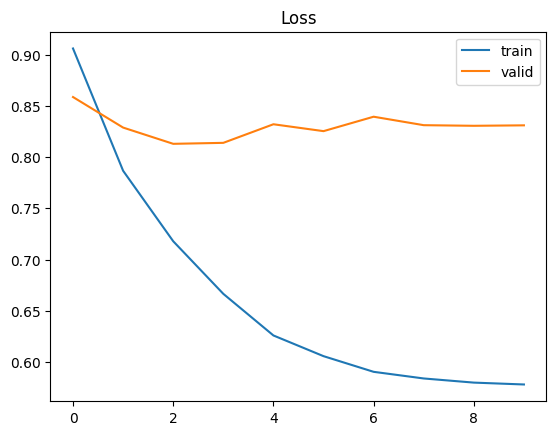

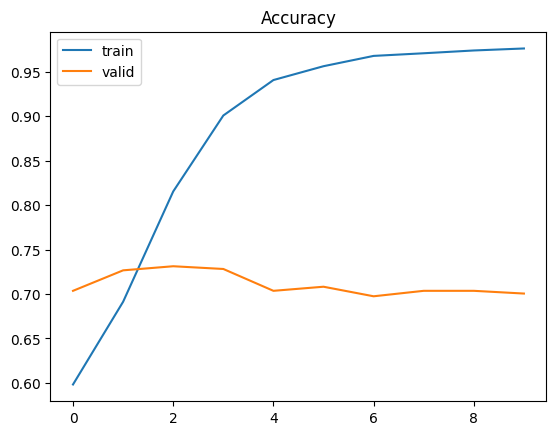

In [29]:
plot_history(multimodal_history)

In [30]:
def get_predictions(model: torch.nn.Module, dataloader: DataLoader) -> Tuple[np.ndarray, np.ndarray]:
    model.eval()
    predictions = []
    true_labels = []
    with torch.no_grad():
        for input_ids, attention_mask, image_features, sentiment in dataloader:
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            image_features = image_features.to(device)

            preds = model(input_ids, attention_mask, image_features)

            preds = preds.cpu().detach().numpy()
            sentiment = sentiment.cpu().detach().numpy()

            preds = np.argmax(preds, axis=1).flatten().tolist()
            sentiment = np.argmax(sentiment, axis=1).flatten().tolist()

            predictions.extend(preds)
            true_labels.extend(sentiment)

    return np.array(predictions), np.array(true_labels)

In [31]:
y_pred, y_true = get_predictions(multimodal_model, test_dataloader)

In [32]:
def get_classification_report(y_true, y_pred, labels):
    print(classification_report(y_true, y_pred, target_names=labels))
    ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred, normalize="true"), display_labels=labels).plot()

              precision    recall  f1-score   support

    negative       0.75      0.71      0.73       245
     neutral       0.39      0.46      0.42       124
    positive       0.82      0.79      0.81       282

    accuracy                           0.70       651
   macro avg       0.65      0.66      0.65       651
weighted avg       0.71      0.70      0.71       651



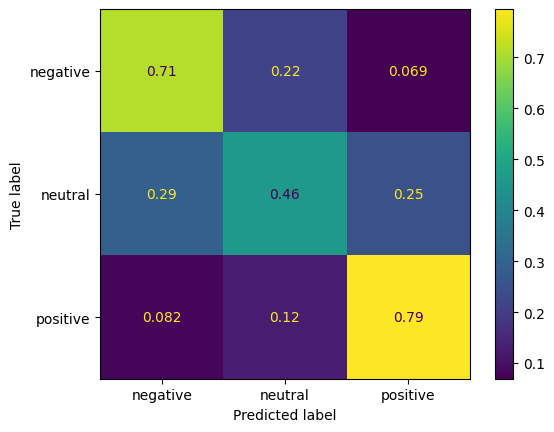

In [33]:
get_classification_report(y_true, y_pred, label_encoder.classes_)

## Train for implementation

In [34]:
input_ids, attention_masks = transform_sentences(image_info_df["clean_caption"].to_list())
image_features = transform_images(image_info_df["image_path"].to_list(), vit_feature_extractor)
labels = F.one_hot(torch.tensor(image_info_df["label"].to_list()).to(torch.int64)).to(torch.float64)

100%|██████████| 3255/3255 [00:37<00:00, 87.45it/s] 


In [35]:
tensor_dataset = TensorDataset(input_ids, attention_masks, image_features, labels)

In [36]:
dataloader = DataLoader(
    tensor_dataset,
    batch_size=BATCH_SIZE,
    sampler=SequentialSampler(tensor_dataset),
)

In [37]:
# train for implementation

NUM_TRAIN_EPOCHS = 5

result_multimodal_vision_model = MultimodalVisualSentimentModel(
    num_classes=NUM_CLASSES,
    language_module=language_model,
    visual_module=visual_model,
    language_model_dim=BERT_OUTPUT,
    visual_model_dim=VISUAL_OUTPUT,
    fusion_dim=FUSION_DIM,
    dropout_prob=DROPOUT,
)
result_multimodal_vision_model.to(device)


for _ in tqdm(range(NUM_TRAIN_EPOCHS)):
    train(result_multimodal_vision_model, dataloader, optimizer, loss_function)

100%|██████████| 5/5 [05:40<00:00, 68.16s/it]


In [39]:
import os
from pathlib import Path


MODEL_DIR = Path("../../models")
if not os.path.exists(MODEL_DIR):
    os.mkdir(MODEL_DIR)

result_multimodal_vision_model.to("cpu")
torch.save(result_multimodal_vision_model, MODEL_DIR / "sentiment_visual_model.cfg")